# The rise and fall of the Islamic State and its coverage in the Guardian

## Introduction
The Islamic State (IS) is a terrorist militant group that follows a fundamentalist jihadist doctrine of Sunni Islam. It gained global prominence when in the first few months of 2014 it managed to drive Iraqi forces out of important Western Iraqi cities. In the same year IS captured the large city Mosul and in the late summer of 2014 it started the Sinjar massacre, a genocidal killing of Yazidi men and women.

The goal of IS was to establish itself as a caliphate, a state led by a group of religious authorities instead of elected officials under a supreme leader – the caliph, now recently murdered Abu Bakr al-Baghdadi – who was believed to be the successor to Prophet Muhammad. June 2014 was an essential month for IS, where the group proclaimed itself a worldwide caliphate and began referring to itself as the Islamic State. At its peak, IS controlled a territory roughly the size of New Zealand, inhabited by roughly ten million people. Although the rise of IS originates in 1999, the first terrorist attack carried out by IS was in March 2013. The fall of IS has still not truly come, yet it is widely considered to be around December 2017, when IS had lost 95% of its territory. The Iraqi Prime Minister Haider al Abadi declared victory over the Islamic State in Iraq on December 9, 2017.

Despite its terrotorial surge in the Iraq and Syria, IS is most widely known for its videos of beheadings and other types of executions of both soldiers and civilians, including journalists and aid workers, and its destruction of cultural heritage sites. What can make terrorism so powerful is its shock value and media coverage. Had IS never videotaped and shared such gruesome acts, it would likely have received much less coverage in Western media. 

This brings me to the purpose of the Exploratory Data Analysis in this notebook. This notebook combines a carefully compiled and comprehensive list of all IS attacks from 2013 until 2017 with all articles published in the Guardian on IS from 2013 until 2017. The Guardian is taken as a proxy for media coverage as it is widely read (30M daily readers) and has all of its content available via an API. Furthermore, the Guardian was found most trusted and most-read of the UK's "quality newsbrands" in a large study in 2017. 

First this notebook explores the comprehensive and almost exhaustive data on all IS attacks in the above timespan, looking at the number of casualties, the medium of attack, the type of target et cetera. It then explores the geographical features of the attacks, and subsequently an analysis of the textual summaries and motives of the attacks is carried out. Lastly, the articles in the Guardian on IS are analysed and some link is sought between the coverage of terrorism and particular features of the terrorist attacks. The focus of this notebook is mostly on analysis of the IS attacks. In short, I attempt to give an indication of an answer the following *Research Questions*:

- How and where did the Islamic State operate?
- How were attacks perpetrated by IS covered in the media?

#### Data Acquisition
The explored data are a combination of two data sets, one compiled by a group of US researchers and the other compiled using the Guardian's API by me. The first data set is a subset of the Global Terrorism Database (https://www.start.umd.edu/research-projects/global-terrorism-database-gtd, which documents more than 190,000 international and domestic terrorist attacks that occurred worldwide since 1970. For each attack, it has data on location, tactics, perpetrators, targets, and outcomes. The sources are unclassified media articles, and the data collection is influenced by fluctuations in access to media coverage over both time and place. I subsetted the data by selecting only entries where `gname == 'Islamic State'`.

All Guardian articles on IS from 2013 until 2017 were first turned into 1825 different .json files, and then turned into one large json file. The API is available at https://open-platform.theguardian.com/. The Open Platform is a public web service for accessing all the content the Guardian creates, categorised by tags and section. The process can be found in the notebook `GuardianDatasetAPI.ipynb`.

### 0.1 Pre-processing

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import seaborn as sns
sns.reset_orig() 
import nltk
from wordcloud import WordCloud, STOPWORDS

#from IPython.display import HTML

#plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.express as px 

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc

# NLP
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer
from textblob import TextBlob, Word, WordList 

from datetime import datetime

sns.set_style('whitegrid') 
pd.options.display.max_columns = 40 

### 0.2 Loading and describing the data

Both data sets are ready to be read in. Only the relevant columns are selected.

In [2]:
try:
    isis = pd.read_csv('../2019mt-st445-project-superlaut/data/isildata.csv',encoding='ISO-8859-1')
    guardian = pd.read_json('../2019mt-st445-project-superlaut/data/isisArticlesGuardian.json', orient = 'columns')
    print('The files have successfully loaded.')
except:
    print('The files could not load, try again.')
    
isis = isis[['eventid', 'iyear', 'imonth', 'iday', 'extended', 'country_txt', 'region_txt', 'city', 
                        'latitude', 'longitude', 'summary', 'nkill', 
                        'nkillus', 'nwound', 'success', 'suicide', 'attacktype1_txt', 'targtype1_txt', 
             'target1','natlty1_txt', 'weaptype1_txt', 'gname', 'motive']]

guardian[['standfirst', 'bodyText', 'wordcount']] = json_normalize(guardian['fields'])[['standfirst', 'bodyText', 'wordcount']]
guardian = guardian[['id', 'sectionName','webPublicationDate','webTitle', 'standfirst', 'bodyText', 'wordcount']]

isis.dtypes
guardian.dtypes

print ('The isis data has', isis.shape[0], 'rows and', isis.shape[1] ,'columns')
print ('The Guardian data has', guardian.shape[0] ,'rows and', guardian.shape[1] ,'columns')

The files have successfully loaded.
The isis data has 5613 rows and 23 columns
The Guardian data has 3860 rows and 7 columns


Each observation in the ISIS data is comprised of 23 variables, a brief description and summary statistics are as follows:

* **eventid**: A unique ID identifying a particular terrorist attack
* **iyear**: Year of attack, ranged from 2013-2017. The first IS attack is on 2013-03-12
* **imonth**: Month of attack
* **iday**: Day of attack
* **extended**: 1 if the attack was perpetrated over more than 1 day, 0 else. 7.8% of attacks are extended.
* **country_txt**: Country where the attack was perpetrated. 25 countries in total, of which Iraq appears most frequently (85%).
* **region_txt**: Region where the attack was perpetrated. Middle East & North Africa appear most frequently (99%).
* **city**: City where the attack was perpetrated.
* **latitude**: Latitude of location where the attack was perpetrated.
* **longitude**: Longitude of location where the attack was perpetrated.
* **summary**: A textual description of the attack.
* **motive**: A textual description of the motive of the attack.
* **nkill**: Number of deaths as a result of the attack. Over half the attacks cause less than three deaths.
* **nkillus**: Number of US citizen deaths. 19 in total.
* **nwound**: Number of wounded as a result of the attack, independent of number of deaths.
* **success**: 1 indicates if the attack was successful, 0 else. 15% is unsuccessful.
* **suicide**: 1 indicates if the attack was a suicide, 0 else. 23% of the attacks are suicides. 
* **attacktype1_txt**: Indicates the type of the attack. 65% are bombings/explosions.
* **targtype1_txt**: Indicates who was targeted by the attack in categories. More than half of all attacks are target at either citizens or military.
* **target1**: A specific description of the target of the attack.
* **natlty1_txt**: Indicates the nationality of the targets. Mostly Iraqis. 

Each observation in the Guardian data is comprised of 7 variables

* **id**: A unique ID identifying the article in the Guardian.
* **sectionName**: Indicates in which section of the Guardian the article was hosted. Half are within World News, one in six in opinion.
* **webPublicationDate**: Indicates the datetime the article was published in the Guardian.
* **webTitle**: The title of the article.
* **standfirst**: Contains the heading of the article.
* **bodyText**: Contains the full text of the article.
* **wordcount**: Indicates the wordcount of an article. 

### 0.3 Cleaning the data
The data are historical and often have very delicate context. First missing data are checked and, if necessary, filled. Then some new columns for plotting are created. Most of the groupby and boolean operations are carried out within the making of the plots.

motive             4620
nwound              839
nkill               547
longitude            29
latitude             29
natlty1_txt           5
attacktype1_txt       0
dtype: int64


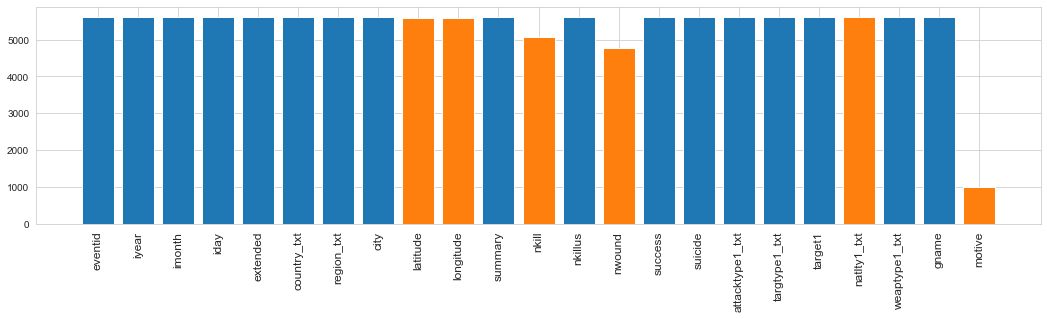

In [3]:
print(isis.isnull().sum().sort_values(ascending=False).head(7))

nulls = abs(isis.isnull().sum()-5613)

anyNulls = [i if i < 5613 else 0 for i in nulls]

fig = plt.subplots(figsize=(18, 4))
plt.bar(nulls.index, nulls.values)
plt.bar(nulls.index, anyNulls)
plt.xticks(rotation = 90, fontsize = 12);
plt.show()

**Filling NAs**

Evidently, there are six columns with missing data. I will manually check the reasons for these missing data, to try to get a sense of why they are missing and how this problem can be solved.

Entries with missing longitude and latitude involve acts of which it is not known, despite thorough analysis of unclassified media articles, where the attack was carried out precisely. Examples include hostage taking and many of the videos posted by IS of beheadings. Longitude and latitude are only necessary for geographical mappings, and missing 29 out of 5680 entries is not problematic. Inferring these data from the descriptions is not possible either, as otherwise the compilers from the Global Terrorism Database would have done so.

Entries with missing nationality of the target are all bombings of which little detail is known. Again, these five entries are not essential in the scope of 5680 attacks. Can be filled with the word 'Unknown'.

Entries with missing nkill and nwound are ambiguous in their nature. Many include attacks where no information regarding possible casualties is available, or of which the outcome is unknown (e.g. people taken hostage of whom is not know whether they are alive now). A solution is to fill the NAs with the median of nkill and nwound, as there appears to be no real distinction in the fatality and types of attacks of which the nkill and nwound are or are not known.

Many entries for motive are missing. That is okay as these are only part of a wordcloud and will not be used for anything else.

In [4]:
isis.nwound.fillna(np.nanmedian(isis.nwound), inplace = True)
isis.nkill.fillna(np.nanmedian(isis.nkill), inplace = True)
isis.natlty1_txt.fillna('Unknown', inplace=True)

#isis.target1 = isis.target1.replace('unk','unknown')

# Creating two new variables relevant for the geographical analysis and modelling
isis['casualties'] = isis['nkill'] + isis['nwound']
isis['successful'] = isis.casualties.apply(lambda x: 0 if x == 0 else 1) 

# Making a date column, some iday and imonth entries are 0. Turn these into 1.
isis['iday'] = isis['iday'].apply(lambda day: day + 1 if day == 0 else day)
isis['imonth'] = isis['imonth'].apply(lambda month: month + 1 if month == 0 else month)
year = isis['iyear'].astype(str)
month = isis['imonth'].astype(str)
day = isis['iday'].astype(str)
isis['date'] = year + "-" + month + "-" + day
isis['date'] = pd.to_datetime(isis['date'])

# Rewriting the date column from the Guardian
guardian['webPublicationDate'] = pd.to_datetime(guardian['webPublicationDate'])
guardian['wordcount'] = guardian['wordcount'].astype(dtype = 'int64')

## 1. Terrorist attacks by ISIS over the years

### 1.1 Descriptive statistics and predicting successfulness
The 5613 distinct terrorist attacks of ISIS have trends. In fact, most of them occurred in Iraq and Syria, and the frequency of attacks increased from 2013 onwards, decreasing from 2016. Some exploratory analyses show that:

In [5]:
print('Country with the largest number of terrorist attacks:',isis['country_txt'].value_counts().index[0])
print('Region with largest number of terrorist attacks:',isis['region_txt'].value_counts().index[0])
print('Maximum people killed in an attack are:',isis['nkill'].max(),'that took place in',isis.loc[isis['nkill'].idxmax()].country_txt)

Country with the largest number of terrorist attacks: Iraq
Region with largest number of terrorist attacks: Middle East & North Africa
Maximum people killed in an attack are: 1570.0 that took place in Iraq


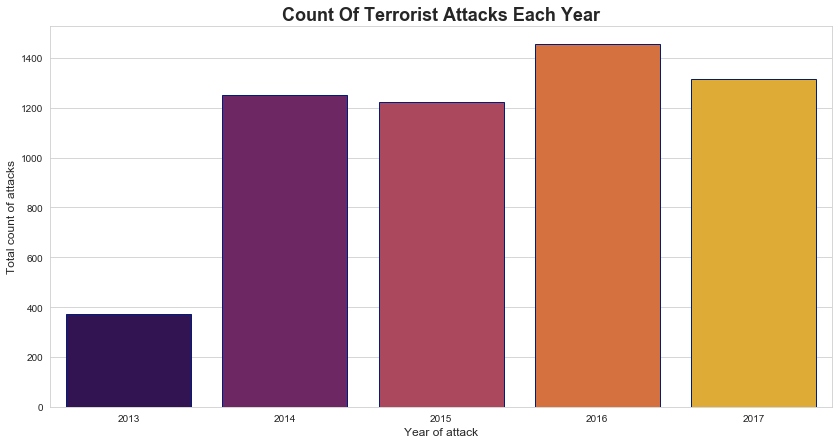

In [7]:
plt.subplots(figsize=(14,7))
sns.countplot('iyear', data=isis, palette='inferno', edgecolor=sns.color_palette('dark',1))
plt.title('Count Of Terrorist Attacks Each Year', fontweight = 'bold', fontsize = 18)
plt.xlabel('Year of attack', fontsize = 12)
plt.ylabel('Total count of attacks', fontsize = 12)
plt.show()

The attack with the most victims was the Camp Speicher massacre, where more than 1500 Iraqi army members were surrounded by IS fighters and murdered. The number of attacks from 2014-2017 are around 1200, equivalent to more than 3 per day on average. Many of these were clearly not covered in Western media. 

The plot below displays what methods the terrorists used in their attacks.

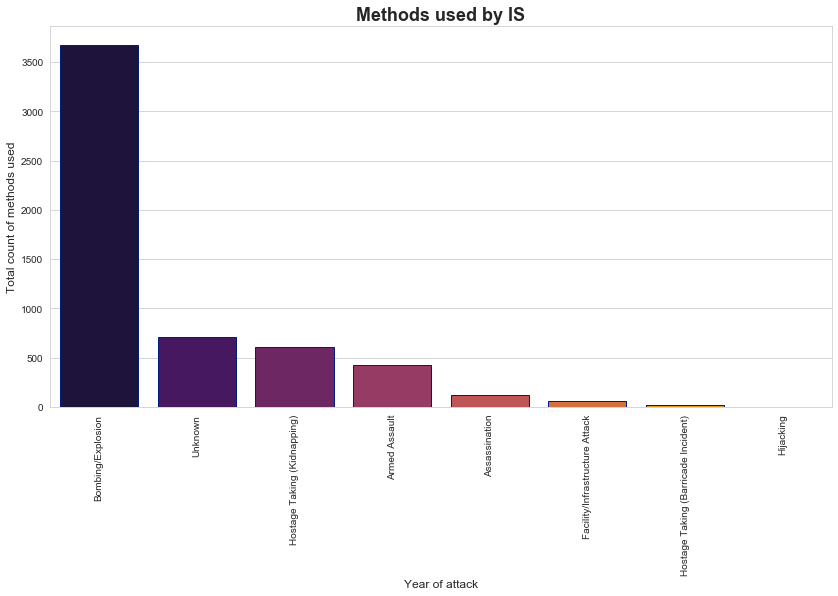

In [8]:
#Attacking methods by terrorist
plt.subplots(figsize=(14,7))
sns.countplot('attacktype1_txt', data=isis,palette='inferno', order=isis['attacktype1_txt'].value_counts().index, edgecolor=sns.color_palette('dark',1))
plt.title('Methods used by IS', fontweight = 'bold', fontsize = 18)
plt.xlabel('Year of attack', fontsize = 12)
plt.ylabel('Total count of methods used', fontsize = 12)
plt.xticks(rotation = 90)
plt.show()

By far most of the attacks were carried out through bombing or explosions: this includes suicide bombings, placing mines, shelling places and blowing up property. Many of the attacks are carried out in an unknown manner, this usually means that only the victims are known and there is no public knowledge as to what happened precisely. The third largest category is that for which IS is most known, namely hostage taking and kidnapping. Especially when Westerners were taken hostage, this would induce fear throughout the Western world and cause most media coverage. 

At this point we have looked at both the number of attacks each year and the methods used, the plot below inspects the combination of these two.

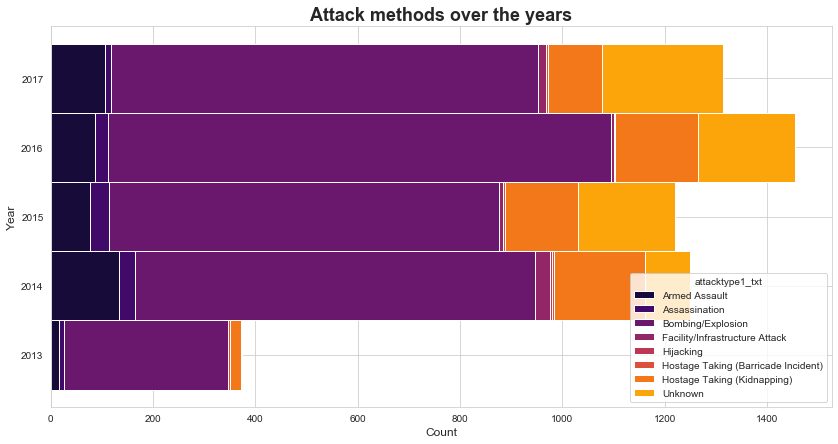

In [9]:
pd.crosstab(isis.iyear,isis.attacktype1_txt).plot.barh(stacked=True,width=1,color=sns.color_palette('inferno',9))
fig = plt.gcf()
fig.set_size_inches(14,7)
plt.title('Attack methods over the years', fontweight = 'bold', fontsize = 18)
plt.xlabel('Count', fontsize = 12)
plt.ylabel('Year', fontsize = 12)
plt.show()

This graph is not extremely informative. Indeed, it confirms that bombings/explosions are the most promininet type of attack used, yet there seems to be no real difference in attack methods over the years. The most important observation is that in 2014 armed assault and hostage takings were the most used types of attack, and this declined over the years after 2014. However, the share of Unknown types of attacks also increased significantly. This could simply mean that hostage taking and armed assault did not decline, but that they were simply not identified as often as the information regarding the attacks had decreased.

The graph below gives another relevant indication of how IS operates, namely, it shows what the targets of the attacks were mostly. A countplot is below:

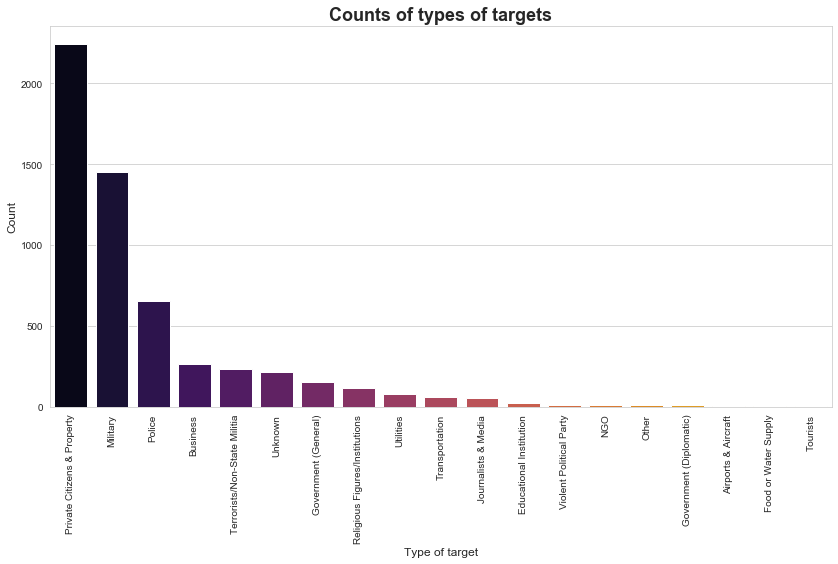

In [10]:
plt.subplots(figsize=(14,7))
sns.countplot(isis['targtype1_txt'], palette='inferno', order=isis['targtype1_txt'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Counts of types of targets', fontweight = 'bold', fontsize = 18)
plt.xlabel('Type of target', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.show()

The most targeted group are private citizens and millitary/police. This is in line with IS methods: spreading fear through random and targeted attacking of citizens who did not adhere to IS' religious ideas. To expand its territory, IS mostly had to fight Iraqi and Syrian military and police. This explains the second and third pillar. 

As a final part of these descriptive statistics, I will attempt to predict whether a terrorist attack will be successful or not. As this is an Exploratory Data Analysis I will not try more than one type of Machine Learning method. As successfulness is a binary outcome variable, I will use logistic regression. To predict whether an attack will be successful or not I will use both categorical and numerical features. The categorical features are the country where the attack was carried out, the attack type, target type, and weapon type. These are all converted using one hot encoding. The numerical variables are both binary, namely, whether an attack lasted longer than one day and whether the attack was a suicide or not. I will leave out the interpretation of parameters as the endgoal of this notebook is EDA.

F1-score: 0.9286365016702096
Best parameter: {'C': 0.5718571428571428}
[[  89  187]
 [  48 1529]]


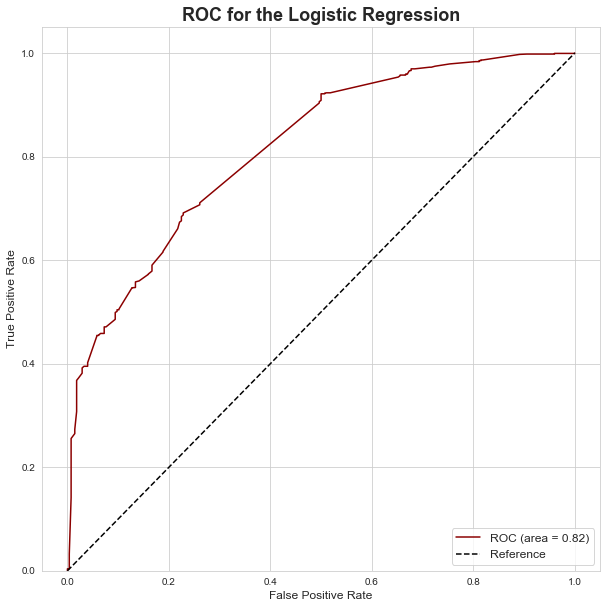

In [11]:
X = isis[['country_txt', 'attacktype1_txt',
               'targtype1_txt', 'weaptype1_txt', 'extended', 'suicide']]
X_onehot = pd.get_dummies(X, columns=['country_txt', 'attacktype1_txt','targtype1_txt', 'weaptype1_txt'], prefix = ['country_txt', 
                                        'attacktype1_txt','targtype1_txt', 'weaptype1_txt'])
y = isis['successful']
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.33, random_state = 42)

lr = LogisticRegression(random_state = 0).fit(X_train, y_train) 
lr_parameters = {'C': np.linspace(0.001, 1, 50),}
lr_grid = GridSearchCV(lr, lr_parameters, scoring = 'f1', cv = 5, n_jobs = -1, error_score = 0)
lr_grid.fit(X_train, y_train)

print('F1-score:', lr_grid.score(X_test, y_test))
print('Best parameter:', lr_grid.best_params_)
print(confusion_matrix(y_test, lr_grid.best_estimator_.predict(X_test)))

fpr, tpr, _ = roc_curve(y_test, lr_grid.best_estimator_.predict_proba(X_test)[:, 1])
auc_ = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(fpr, tpr, label='ROC (area = %0.2f)' % auc_,
         color='darkred')
ax.plot([0, 1], [0, 1], ls='dashed', color = 'black', label = 'Reference')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC for the Logistic Regression', fontsize=18, fontweight = 'bold')
ax.legend(loc="lower right", fontsize=12)
plt.show()

The plot above indicates the modelling is far from perfect, but at least the explanatory variables do give some sense of prediction. The confusion matrix indicates that the model predicts successful attacks reasonably well, but underestimates the number of unsuccessful attacks.

### 1.2 Geographical Analysis

This part of the notebook showcases where IS operated through some descriptive and interactive plots. The first plot gives an indication of which countries IS was most active in.

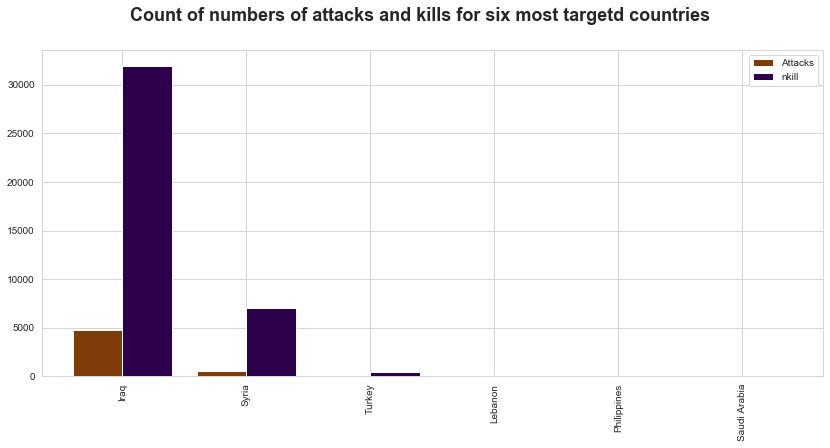

In [12]:
sixCountryCount = isis['country_txt'].value_counts()[:6].to_frame()
sixCountryCount.columns = ['Attacks']
sixCountryKillCount = isis.groupby('country_txt')['nkill'].sum().to_frame()

sixCountryCount.merge(sixCountryKillCount, left_index=True, right_index=True, how='left').plot.bar(width=0.8, colormap = 'PuOr')
fig = plt.gcf()
fig.set_size_inches(14, 6)
fig.suptitle('Count of numbers of attacks and kills for six most targetd countries', fontweight = 'bold', fontsize = 18)

plt.show()

The results indicate that overwhelmingly IS fought in and targeted Iraq and Syria. This makes sense, as their territory was in these two countries. 

The next plot is a bit more complex, and maps over the years the count of attacks in each countries.

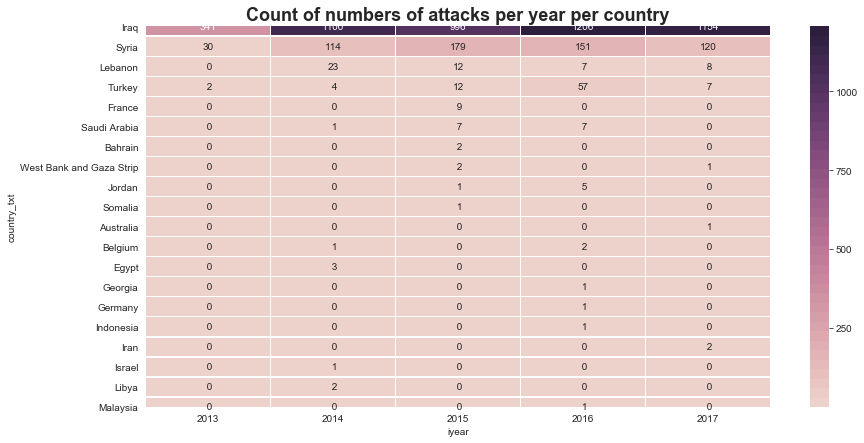

In [13]:
isis_grouped = isis.groupby(['country_txt','iyear'])['gname'].count().unstack()
isis_grouped = isis_grouped.sort_values([2015], ascending=False)
isis_grouped.fillna(0, inplace = True)
plt.subplots(figsize=(14,7)) 
cmap = sns.cubehelix_palette(40)
plt.title('Count of numbers of attacks per year per country', fontweight = 'bold', fontsize = 18)
g = sns.heatmap(isis_grouped[0:20], annot=True, fmt="2.0f", cmap = cmap, linewidths=.6, vmin=0.01)
plt.show()
# Downgrade your version of matplotlib to make this graph be properly outlined again. The most recent version broke heatmaps.

Notably, some regions were only attacked from 2015 onwards. In 2015, IS expanded into a network of affiliates in at least eight other countries. Its branches, supporters, and affiliates increasingly carried out attacks beyond the borders of its so-called caliphate. Furthermore, for all countries except for the Philippines and Iraq the number of attacks declined from 2016 to 2017. IS was losing most of its power from the beginning of 2017 onwards. 

The next plot is interactive and plots all terrorist events, making a distinction between events with and without fatalities, over the entire region where IS committed terrorist events. You can navigate through the plot however you like. The size of a circle indicates the number of injuries/fatalities.

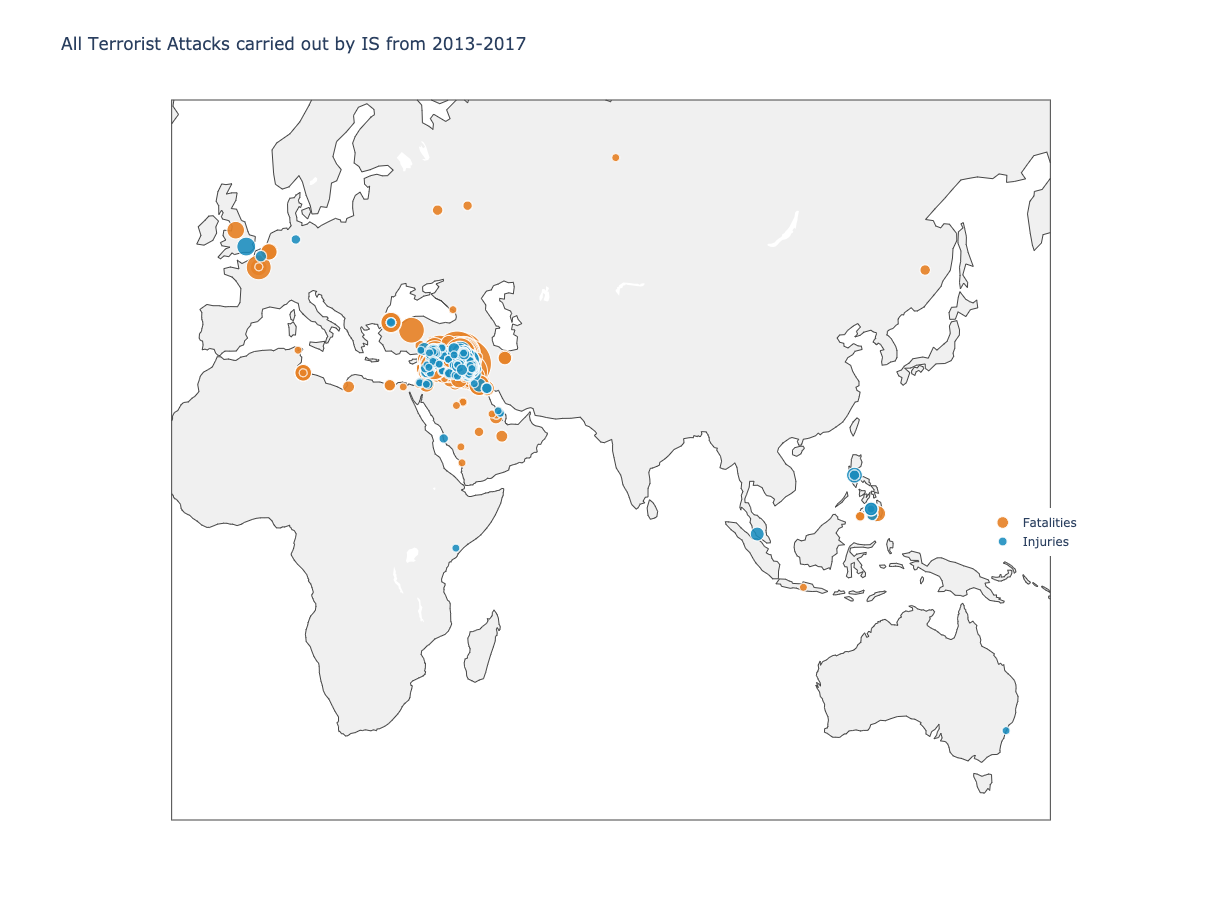

In [14]:
fatalAttacks = dict(
           type = 'scattergeo',
           locationmode = 'ISO-3',
           lon = isis[isis.nkill > 0]['longitude'],
           lat = isis[isis.nkill > 0]['latitude'],
           text = isis[isis.nkill > 0]['city'],
           mode = 'markers',
           name = 'Fatalities',
           hoverinfo = 'text+name',
           marker = dict(
               size = isis[isis.nkill > 0]['nkill'] ** 0.25 * 8,
               opacity = 0.92,
               color = 'rgb(230, 130, 40)')
           )
nonFatalAttacks = dict(
         type = 'scattergeo',
         locationmode = 'ISO-3',
         lon = isis[isis.nkill == 0]['longitude'],
         lat = isis[isis.nkill == 0]['latitude'],
         text = isis[isis.nkill == 0]['city'],
         mode = 'markers',
         name = 'Injuries',
         hoverinfo = 'text+name',
         marker = dict(
             size = (isis[isis.nkill == 0]['nwound'] + 1) ** 0.25 * 8,
             opacity = 0.88,
             color = 'rgb(25, 140, 190)')
         )
layout = go.Layout(
    title = 'All Terrorist Attacks carried out by IS from 2013-2017',
     showlegend = True,
         legend = dict(
             x = 0.85, y = 0.4
         ),
     geo = dict(
             lonaxis = dict( range= [ -15.0 ,160.0] ),
             lataxis = dict( range= [ -35.0, 70.0 ] ),
             projection = dict( type = 'mercator'),
             showland = True,
             landcolor = 'rgb(240, 240, 240)',
             subunitwidth = 1,
             subunitcolor = 'rgb(220, 220, 220)',
             countrywidth = 1,
             countrycolor = 'rgb(210, 210, 210)',
             showlakes = True,
             lakecolor = 'rgb(260, 260, 260)'),
     width=1100,
    height=900
             
         )

data = [fatalAttacks, nonFatalAttacks]
figure = dict(data = data,layout = layout)
iplot(figure)

The plot below is also interactive and uses a different type of interface for geographical, interactive plots, making use of the open-street-map framework. It is only focussed on Iraq, and looks at the geographical distribution of the types of attacks, with size of the circle representing the number of casualties (sum of deaths and wounded).

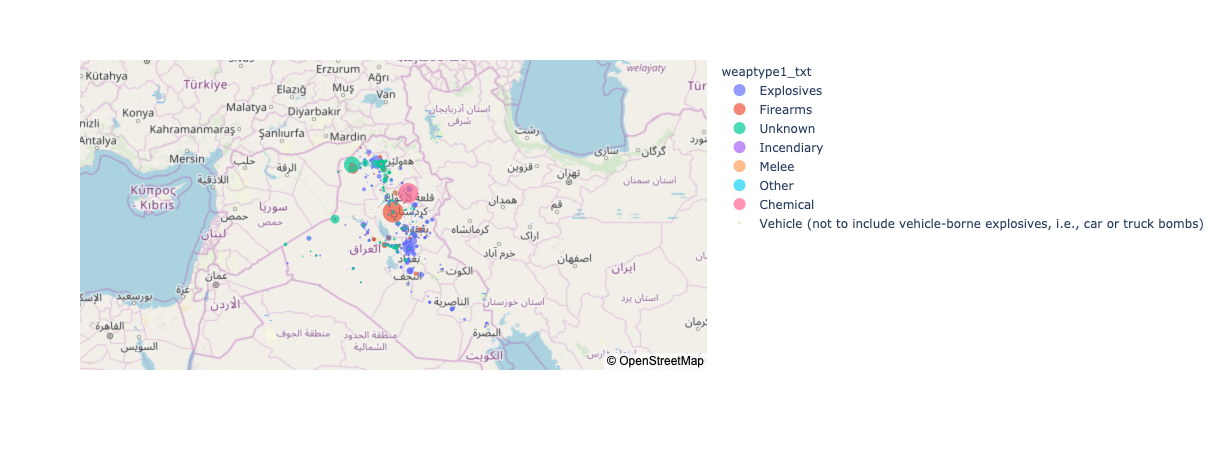

In [15]:
iraq = isis[isis.country_txt == 'Iraq']
fig = px.scatter_mapbox(iraq, lat="latitude", lon="longitude", color="weaptype1_txt", size="casualties",\
                       color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=4)
fig.update_layout(mapbox_style="open-street-map") 
fig.show()

### 1.3 Text analysis on motives and summary

This section will look at a wordcloud of all motives, to give some sense of what the motives were for IS' attacks. Afterwards, all summaries of the attacks will be mapped over time, again in the form of wordclouds. This can give some sense of how the attacks may have changed or remained the same over time.

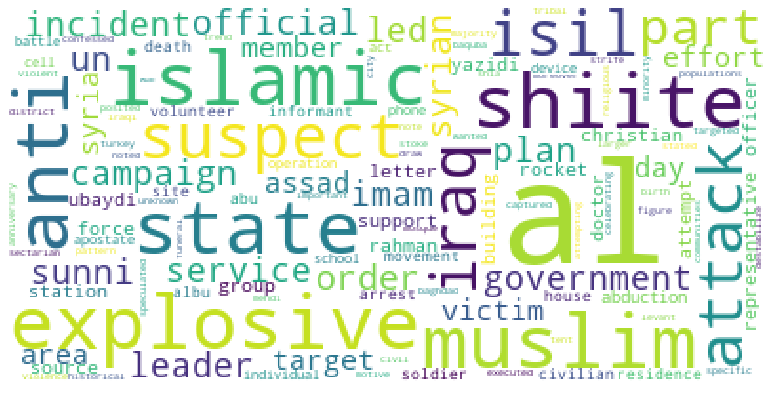

In [32]:
motive_cleaned = isis['motive'].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
tokenised_words = nltk.tokenize.word_tokenize(motive_cleaned)
word_freq = nltk.FreqDist(tokenised_words)
word_nostop_freq = nltk.FreqDist(w for w in tokenised_words if w not in STOPWORDS) 
wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white').generate(" ".join(word_nostop_freq))
plt.imshow(wordcloud)

fig=plt.gcf()
fig.set_size_inches(14,7)
plt.axis('off')
plt.show()

The words can grouped into roughly three categories. First is that of the Islam. Words include Islamic, Sunni, muslim, al (from Abu Bakr al-Baghdadi, the supreme leader of IS, al-qaida, al-Assad), shiite, Imam, Rahman (an alternative word for God in the Islam), Sunni, Abu. Second is that of location and targets: Syrian, Iraq, Syria, Yazidi (a people that IS committed genocide on), house, government, soldier. Third is that of the type of attack, with the prominent words being victim, attack, explosive, phone, device (all three related to the most carried out type of attack), abducation.

Plotting wordclouds over the years for the motive shows that the motives roughly remain the same. The attack summaries, however, do change over the years. The plots below demonstrate this.

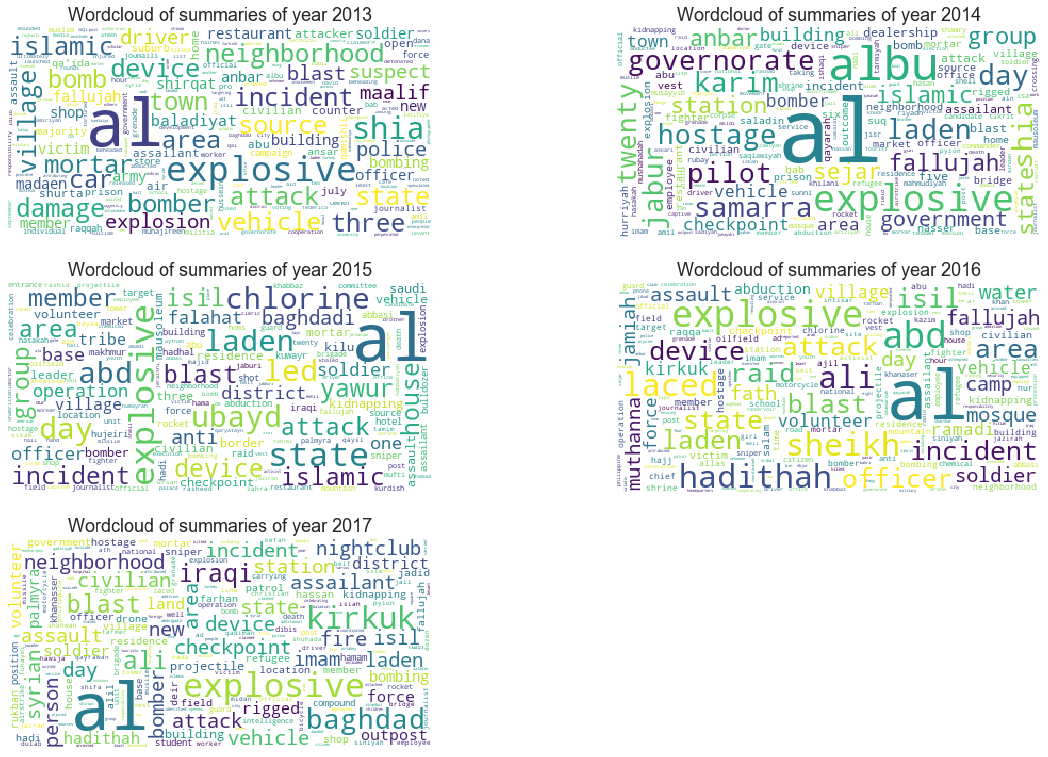

In [34]:
years = [2013,2014,2015,2016,2017]
plt.figure(figsize=(20,18))
gs = gridspec.GridSpec(4, 2)

for i, cn in enumerate(years):
    ax = plt.subplot(gs[i])
    
    isis_per_year = isis[isis['iyear'] == cn]
    summary_per_year = isis_per_year['summary'].str.lower().str.cat(sep=' ')
    tokenised_words = nltk.tokenize.word_tokenize(summary_per_year)
    word_freq = nltk.FreqDist(tokenised_words)
    word_nostop_freq = nltk.FreqDist(w for w in tokenised_words if w not in STOPWORDS) 
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color='white').generate(" ".join(word_nostop_freq))
    ax.imshow(wordcloud)
    ax.set_title('Wordcloud of summaries of year ' + str(cn), fontsize = 18)
    ax.axis('off')

Two words appear prominently in all wordclouds. The most obvious is 'al', part of the supreme leader's name and of many Arabic words (and al-qaida). Second is 'explosive'; this is clearly the most typical attacking style of IS. From there there seem to be many distinct words in all clouds. From the summaries we can make some inferences, which I will do chronologically.

In 2013, the words bomb, mortar, car bomber, explosion, vehicle and bombing appear. IS started mostly with such types of attack.  Shirtcat, Maalif and Raqqah are already mentioned, three cities where IS later became active. In 2014, the words hostage and government start appearing. The types of attack started shifting and more people were taken hostage and the government started intervening more on the one hand, and being attack more on the other. Jabur and Fallujah appear, two other cities were IS became active in that year. 2015 becomes more grim. The word chlorine appears prominently, as IS started using chlorine in their attacks against for instance Peshmerga, one of the forces fighting back against IS. Falahat and Baghdadi appear too, two large cities in Iraq, where IS was very active that year. 2016 is similar to 2013 in that it contains many bombing-related type of words. This is understandable, as such attacks never decreased and the summaries are factual descriptions of the events that took place. Hadithah is a village in Iraq, controlled by IS from 2014 onwards. The Iraqi government regained the territory later on in 2016. 2017, altough this was the final year that IS controlled large territory in both Syria and Iraq, the words do not seem to indicate any of that. Again, many of the words are related to explosions (rigged, bomber, device, blast). Palmyra is shown, an ancient and important city in Syria, that year regained by the Iraqi government. The word nightclub appears prominently too, which could be explained by IS attacking nightclubs as the activities pursued there were considered sinful by IS doctrine. Notably, words relating to Syria seem te be missing (except for Assad, the prime minister of Syria then, and Palmyre). It is likely these appeared much less frequently than words related to Iraq, as IS mostly operated there. 

## 2. The Guardian covering Islamic State

### 2.1 Coverage over time
This section looks at the monthly count of articles in the Guardian on IS, and compares is to the true number of attacks and true number of deaths as a consequence of IS attacks. 

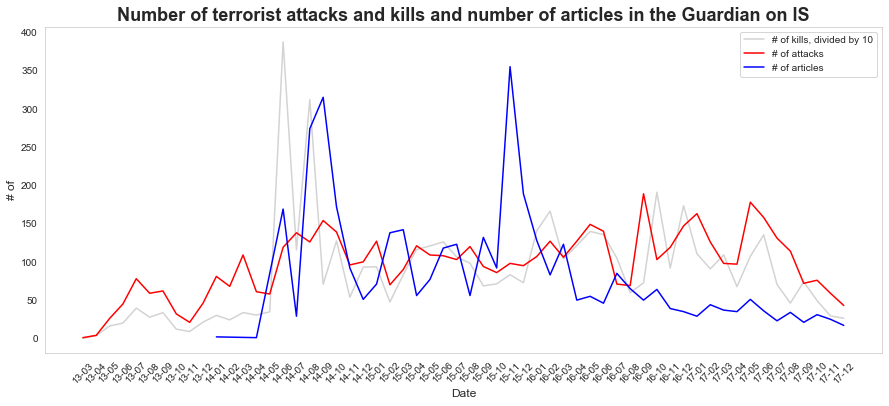

In [47]:
guardian['month'] = [i.strftime('%y-%m') for i in guardian['webPublicationDate']]
per_month_cnt_guardian = pd.DataFrame(guardian.groupby('month')['id'].count())
per_month_wordcnt_guardian = pd.DataFrame(guardian.groupby('month')['wordcount'].sum())
per_month_worldnews_guardian = pd.DataFrame((guardian.loc[guardian['sectionName'] == 'World news']).groupby('month')['id'].count())

# Wordcount and article count correlate 0.97, number of articles in World News monthly and number of articles correlate 0.98
np.corrcoef(per_month_wordcnt_guardian.wordcount, per_month_cnt_guardian.id)[0][1]
np.corrcoef(per_month_worldnews_guardian.id, per_month_cnt_guardian.id)[0][1]

isis['month'] = [i.strftime('%y-%m') for i in isis['date']]
per_month_attack_isis = pd.DataFrame(isis.groupby('month')['eventid'].count())
per_month_casualties_isis = pd.DataFrame(isis.groupby('month')['casualties'].sum())
# Number of kills is scaled, divided by 8
per_month_kills_isis = pd.DataFrame(isis.groupby('month')['nkill'].sum()/8)

plt.subplots(figsize=(15, 6))

plt.plot(per_month_kills_isis.index, per_month_kills_isis['nkill'], label = '# of kills, divided by 8', color = 'lightgrey')
plt.plot(per_month_attack_isis.index, per_month_attack_isis['eventid'], label = '# of attacks', color = 'red')  
plt.plot(per_month_cnt_guardian.index, per_month_cnt_guardian['id'], label = '# of articles', color = 'blue')

plt.xticks(per_month_attack_isis.index, rotation = 45, fontsize = 10)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('# of', fontsize = 12)
plt.title('Number of terrorist attacks and kills and number of articles in the Guardian on IS', fontweight = 'bold', fontsize = 18)
plt.legend()
plt.grid(b=None)
plt.show()

First, I will write a short timeline of IS attacks and compare it to the coverage. On 14-01 (notation for January 2014), IS captured the cities of Fallujah and Ramadi. This is not necessarily discernible on the graph. Interestingly, only on January 2014 the Guardian started covering IS. This means that for over 9 months, IS was operating on a large scale yet it did not seem to gain coverage in a Western newspaper. In those 9 months, only non-Westerners were murdered which definitely plays a role in the coverage.

14-06 was an enormously important month for IS. The number of kills peaks here, as this month includes the Anbar-assault, where more than 1500 Iraqi troops were surrounded and murdered. The first peak in coverage is reached. This month also marks the establishment of IS as a caliphate. Yet this peak is not nearly as impressive as the peaks on 14-08 and 14-09. 14-08 marks the Sinjar massacre, where hundreds of Yazidi men and women were murdered. This was also covered extensively. Even though this still did not concern Westerners, a genocidal type of attack is always extensively covered in worldwide newspapers, as it is considered one of the worst crimes against humanity. Furthermore, this is the month Barack Obama decided that the US would start airstriking parts of Iraq where IS was active. The number of attacks and kills drop in 14-09, but coverage grows even further. IS starts becoming a real threat to Westerners, as an American journalist Steven Sotloff is beheaded and the video is spread via the internet. The world has become scared. On 14-12 the Kurdish Peshmerga and PKK launch the Sinjar offensive, to break up IS transport routes and supply lines. Mosul and Raqqa are captured by IS. Coverage and number of kills show no remarkable trends.

In 2015 IS captured Palmyra. The number of kills and attacks seem to constantly oscillate around the mean, without remarkable trends. The Guardian coverage, however, has its largest peak in 15-11. This marks the Paris attacks on the night of Friday 13 November when gunmen and suicide bombers hit a concert hall, a major stadium, restaurants and bars, almost simultaneously - and left 130 people dead and hundreds wounded. In terms of kills this was not necessarily remarkable for IS, but the Guardian published enormous amounts of articles that month and the month after. The world became even more scared of IS spreading throughout the West. Populist political parties started rising in popularity, anti-refugee and immigrant rhetoric came to dominate the streets.

No other large attack appeared in the West from there onwards. Coverages steadily declines, while number of attacks and kills start increasing again. IS fights its last fights, with a declining trend from 17-03 onwards. This marks IS losing more and more of its territory and power. IS is not truly defeated on 17-12, but the world is getting close.

### 2.2 What do these articles look like?

The dataset contains the body text of all 3680 articles on IS. Plotting a wordcloud was less interesting than expected, and thus this section looks at the most prominent 2-grams appearing in all these articles.

In [51]:
corpus = guardian.bodyText.apply(lambda x: x.split(': ')[-1]).values

vectorizerEnglish2gram = CountVectorizer(ngram_range = (2,2), stop_words = STOPWORDS)
data2 = vectorizerEnglish2gram.fit_transform(corpus)

tokens_df_2gram = pd.DataFrame(data2.A, columns=vectorizerEnglish2gram.get_feature_names())

In [55]:
# Largely inspired by the Peru example
df_2gram = pd.DataFrame(tokens_df_2gram.sum()).sort_values(by = 0, ascending = False).iloc[0:40,]
df_2gram.columns = ['count']

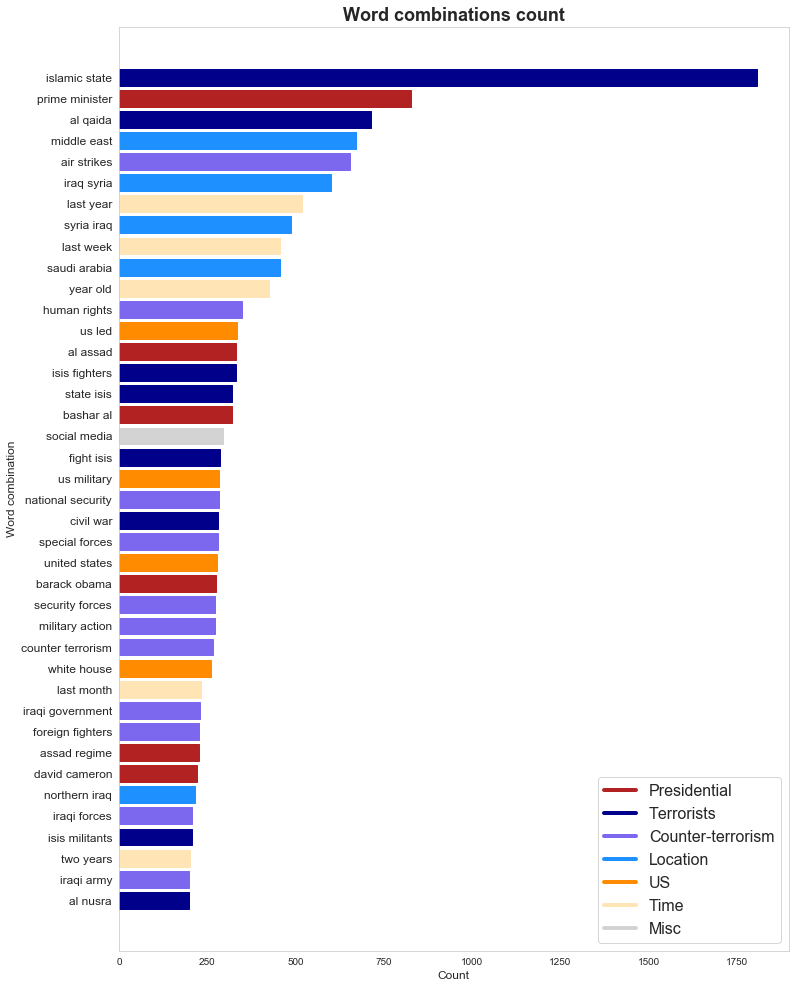

In [56]:
fig, ax = plt.subplots(figsize=(12,17))

barplot = ax.barh(np.arange(len(df_2gram['count'])), df_2gram['count'])
ax.set_yticks(np.arange(len(df_2gram['count'])))
ax.set_yticklabels(df_2gram.index, fontsize = 12)
ax.invert_yaxis()
ax.set_ylabel('Word combination', fontsize = 12)
ax.set_xlabel('Count', fontsize = 12)
ax.set_title('Word combinations count', fontsize = 18, fontweight = 'bold')

colors = {0:'darkblue',1:'firebrick',2:'darkblue',3:'dodgerblue',4:'mediumslateblue',5:'dodgerblue',
         6:'moccasin',7:'dodgerblue',8:'moccasin',9:'dodgerblue',
          10:'moccasin',11:'mediumslateblue',12: 'darkorange',13:'firebrick',14:'darkblue',15:'darkblue',16:'firebrick',
          17:'lightgrey',18:'darkblue',19:'darkorange',
          20:'mediumslateblue',21:'darkblue',22:'mediumslateblue',23:'darkorange',24:'firebrick',25:'mediumslateblue',
          26:'mediumslateblue',27:'mediumslateblue',
          28:'darkorange',29:'moccasin', 30 :'mediumslateblue', 31:'mediumslateblue',32:'firebrick',
          33: 'firebrick', 34: 'dodgerblue', 35:'mediumslateblue', 36:'darkblue',
          37:'moccasin', 38:'mediumslateblue',39:'darkblue'}

for i in colors:
    barplot[i].set_color(colors[i])

politics = plt.Line2D((0,1),(0,0), color='firebrick', linewidth = 4)
terrorism = plt.Line2D((0,1),(0,0), color='darkblue', linewidth = 4)
counterterrorism = plt.Line2D((0,1),(0,0), color='mediumslateblue', linewidth = 4)
location = plt.Line2D((0,1),(0,0), color='dodgerblue', linewidth = 4)
US = plt.Line2D((0,1),(0,0), color='darkorange', linewidth = 4)
time = plt.Line2D((0,1),(0,0), color='moccasin', linewidth = 4)
misc = plt.Line2D((0,1),(0,0), color='lightgrey', linewidth = 4)

ax.legend([politics,terrorism,counterterrorism,location,US,time,misc],
          ['Presidential', 'Terrorists','Counter-terrorism','Location','US','Time','Misc'], fontsize=16)
plt.grid(b=None)
plt.show()

From the outset, the focus of the Guardian articles is very different from the summaries in the Global Terrorism Database. Most notably, the word 'explosive' and anything related to it barely appears. Furthermore, the word 'al' only appears one, in relation with the Syrian president Bashar al-Assad. The focus is much more on general counter-terrorist practices, Presidential official statements, and US intervention. Time and location are general descriptors that indicate that coverage often refers back to older attacks, e.g. explaining how IS developed over the years. This makes sense, as in the news the writer cannot simply assume that the reader knows everything about IS until the time of publishment. 

## 3. Conlusion

This Exploratory Data Analysis attempted to look at two questions, namely how and where did the Islamic State operate, and how were attacks perpetrated by IS covered in the media? For the first question, first the count of all IS attacks was analysed over the years 2013 and 2017, then the types of attacks were looked at. Subsequently, how the types of attacks changed over the years was analysed and the types of victims were analysed. From 2014, there were about 1200 attacks per year, many of which were carried out through bombing/explosisves. A short predictive exercise was carried out, to see what factors determined whether an attack would be successful or not. The variables country of attack, type of attack, target and weapon, and whether the attack was extended or a suicide seemed to predict this reasonably. To further answer the first questions, the geographical features of the attacks were analysed, with two interactive plots respectively displaying all IS attacks in the world and in Iraq. Two other plots indicate that IS mostly operated in Iraq and Syria, but much more in Iraq. Motive and summary analyses showed mostly the cities IS was active in, and some trends in their attacks were discernible.

For the second question, the trends in coverage and number of kills and number of attacks were analysed. Indeed, the hypothesis that mostly attacks related to indirectly or directly the West seems to be confirmed. Furthermore, the content of the articles indicate that the Guardian writes quite factually on the attacks and its most used phrases mostly related to presidential statements, counter-terrorism and the US. Both the IS data set and the Guardian data set contain volumes of interesting data. The relation between coverage and true attacks could be explored in much more detail, yet this is beyond the scope of this EDA.